--> survived:
  - Indica se o passageiro sobreviveu ao naufrágio.
  - Valores: 0 (não sobreviveu) ou 1 (sobreviveu).

--> pclass:
  - Classe da passagem do passageiro.
  - Valores: 1 (primeira classe), 2 (segunda classe), 3 (terceira classe).

--> sex:
  - Sexo do passageiro.
  - Valores: male ou female.

--> age:
  - Idade do passageiro em anos.
  - Valor numérico contínuo. Valores faltantes precisam ser tratados.

--> sibsp:
  - Número de irmãos/irmãs ou cônjuges a bordo do Titanic.
  - Valor numérico inteiro.

--> parch:
  - Número de pais/filhos a bordo do Titanic.
  - Valor numérico inteiro.

--> fare:
  - Tarifa paga pelo bilhete.
  - Valor numérico contínuo.

--> embarked:
  - Porto de embarque do passageiro.
  - Valores: C (Cherbourg), Q (Queenstown), S (Southampton). Valores faltantes precisam ser tratados.

--> class:
  - Classe da cabine do passageiro, duplicata de pclass para conveniência.
  - Valores: First, Second, Third.

--> who:
  - Descrição do tipo de passageiro.
  - Valores: man, woman, child.

--> adult_male:
  - Indica se o passageiro é um homem adulto.
  - Valores: True ou False.

--> deck:
  - Convés onde a cabine do passageiro estava localizada.
  - Valores: Letras de A a G, e NaN para valores faltantes.

--> embark_town:
  - Nome do porto de embarque.
  - Valores: Cherbourg, Queenstown, Southampton. Valores faltantes precisam ser tratados.

--> alive:
  - Indica se o passageiro sobreviveu.
  - Valores: yes ou no.

--> alone:
  - Indica se o passageiro estava viajando sozinho.
  - Valores: True ou False.

In [123]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [124]:
original_df = sns.load_dataset('titanic')

In [125]:
df = sns.load_dataset('titanic')

In [126]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [127]:
#Aqui verificamos que há valores nulos em age, embarked, deck e embarl_town
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Decidimos excluir colunas que já possuem outra correspondente no dataset (alive - survived, class - pclass, adul_tmale - who, sex - who, embark - embark_town)

Com relação aos dados faltantes do embarked, sua maior correlação é com a classe da passagem (veremos que pessoas da primeira classe tendem a embarcar em Cheerbourg, enquanto os de terceira classe em Queenstown), mas também não é o suficiente para podermos prever

Além disso, veremos mais para frente que a maiorida das crianças sobreviveam, mas fora isso, não temos dados suficientemente correlacionados com age para inputar seu valor. O erro médio para inputação por KNN com 5 vizinhos foi por volta de 40%, já o erro inputando pela média da idade por who (child, woman, man) foi de 35%, ainda assim para análises envolvendo age, esse valor está muito alto. Assim sendo, optamos por retirar esses dados.

In [128]:
df.drop(columns=["alive", "class", "adult_male", "sex", "embarked"], inplace=True)
df.dropna(subset=["embark_town", "age"], inplace=True)
df.shape[0]

712

Já para o "deck", como a maioria dos dados estão faltantes, optamos por retirar a coluna do dataframe principal, mas mantemos um dataframe apenas com as linhas que possuiam o valor de "deck" preenchido, visto que pode ser uma informação útil para futuras análises.

In [129]:
#Criando um datafrade com as linhas em que há a informação do 'deck' para poder analisar separadamente depois
df_with_deck = df.dropna(subset=['deck'])
df.drop(columns=['deck'], inplace=True)
print(f'Número de dados com "deck": {df_with_deck.shape[0]}')

Número de dados com "deck": 182


In [130]:
#Dessa forma, retiramos todos os dados faltantes do nosso dataframe
df.isnull().sum()

survived       0
pclass         0
age            0
sibsp          0
parch          0
fare           0
who            0
embark_town    0
alone          0
dtype: int64

In [ ]:
#Função para plotar gráfico com as porcentagens relativas
def plot_relative_percentage(ax, data, x, hue, title):
    counts = data.groupby([x, hue]).size().unstack(fill_value=0)

    total_counts = counts.sum(axis=1)
    percentages = counts.div(total_counts, axis=0) * 100

    percentages = percentages.reset_index().melt(id_vars=[x], value_name='percentage')

    sns.barplot(ax=ax, x=x, y='percentage', hue=hue, data=percentages)
    ax.set_title(title)
    ax.set_ylabel('Porcentagem Relativa')
    ax.set_xlabel(x.capitalize())
    ax.set_ylim(0, 100)
    ax.legend(title=hue.capitalize(), loc='upper right')

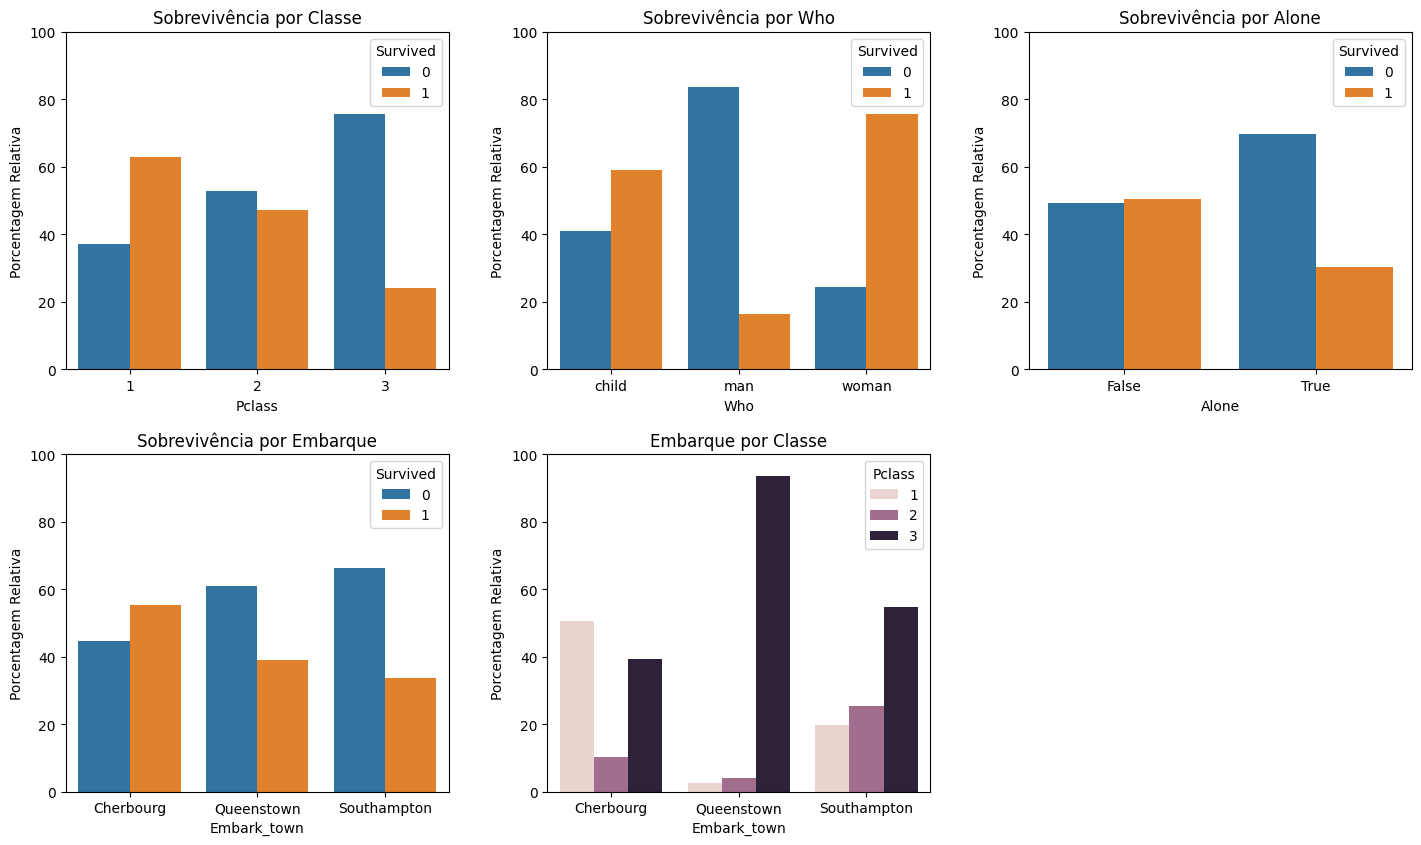

In [131]:
#Criando uma matriz de gráficos com 2 linhas e 3 colunas
fig, axs = plt.subplots(2, 3, figsize=(15, 9))
fig.tight_layout(pad=4.0)

#Análise de sobrevivência por classe: Maioria dos de primeira classe sobreviveram, maioria dos de terceira classe morreram
plot_relative_percentage(axs[0, 0], original_df, x='pclass', hue='survived', title='Sobrevivência por Classe')
#Análise de sobrevivência por who: maioria das mulheres e crianças sobreviveram, maioria dos homens morreram
plot_relative_percentage(axs[0, 1], original_df, x='who', hue='survived', title='Sobrevivência por Who')
#Pessoas sozinhas acabaram por morrer com mais frequência
plot_relative_percentage(axs[0, 2], original_df, x='alone', hue='survived', title='Sobrevivência por Alone')
#Pessoas que embracaram em Cherbourg sobreviveram mais
plot_relative_percentage(axs[1, 0], original_df, x='embark_town', hue='survived', title='Sobrevivência por Embarque')
#Pessoas que embracaram em Cherbourg são majoritariamente de primeira classe, já em Queenstown de terceira classe.
plot_relative_percentage(axs[1, 1], original_df, x='embark_town', hue='pclass', title='Embarque por Classe')

#Escondendo o gráfico vazio
axs[1, 2].axis('off')
plt.show()

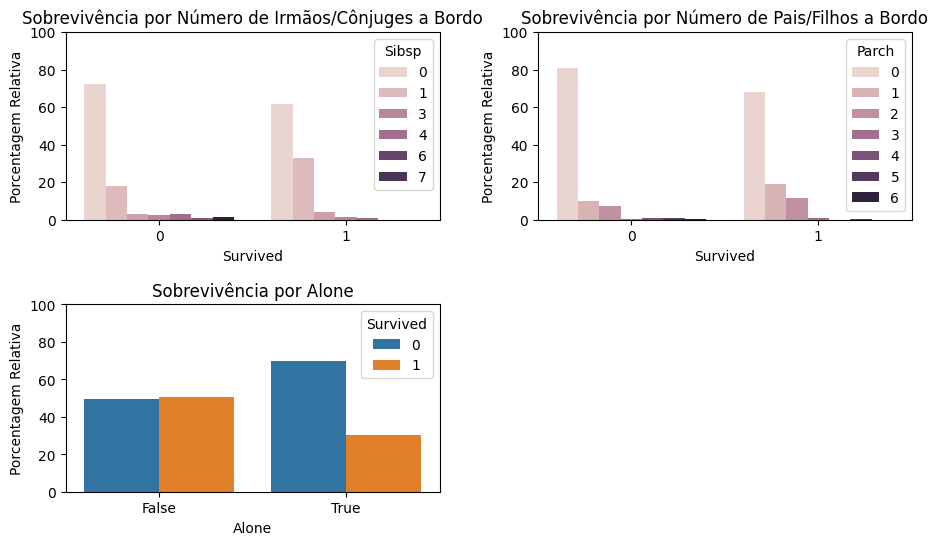

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.tight_layout(pad=4.0)

plot_relative_percentage(axs[0, 0], original_df, x='survived', hue='sibsp', title='Sobrevivência por Número de Irmãos/Cônjuges a Bordo')
plot_relative_percentage(axs[0, 1], original_df, x='survived', hue='parch', title='Sobrevivência por Número de Pais/Filhos a Bordo')
plot_relative_percentage(axs[1, 0], original_df, x='alone', hue='survived', title='Sobrevivência por Alone')

axs[1, 1].axis('off')
plt.show()

In [133]:
"""Para o objetivo do trabalho, a única informação útil que podemos extrair com sibsp e parch é que que a maioria das pessoas que morreram estavam sozinhas, mas essa
informação já está sintetizada em alone, por isso optamos por retirar essas variáveis do dataframe"""
df.drop(columns=["sibsp", "parch"], inplace=True)

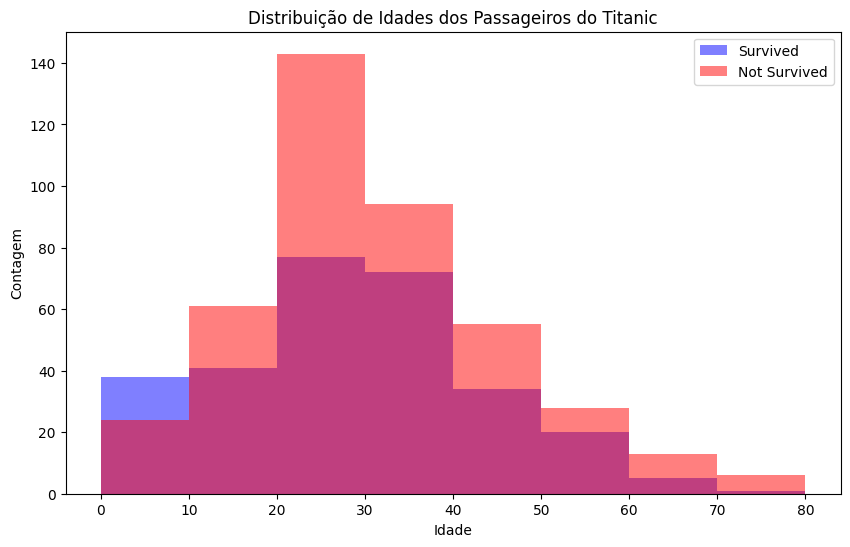

In [134]:
"""Aqui confirmamos que crianças de até 10 anos possuem mais chance de sobreviver"""
#Criando máscaras booleanas para quem sobreviveu e quem não sobreviveu
survived_mask = df['survived'] == 1
not_survived_mask = df['survived'] == 0

#Definindo os bins
bin_edges = list(range(0, int(df['age'].max()+10), 10))

plt.figure(figsize=(10, 6))
plt.hist(df.loc[survived_mask, 'age'], bins=bin_edges, alpha=0.5, color='blue')
plt.hist(df.loc[not_survived_mask, 'age'], bins=bin_edges, alpha=0.5, color='red')

plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.title('Distribuição de Idades dos Passageiros do Titanic')
plt.legend(['Survived', 'Not Survived'])
plt.show()

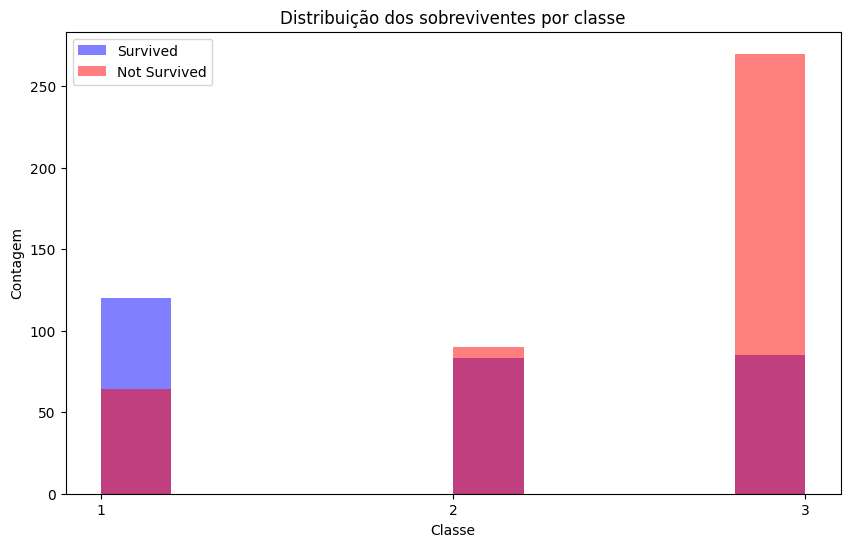

In [135]:
"""Aqui percebemos que pessoas da primeira classe possuem mais chance de sobreviver"""
plt.figure(figsize=(10, 6))
plt.hist(df.loc[survived_mask, 'pclass'], alpha=0.5, color='blue')
plt.hist(df.loc[not_survived_mask, 'pclass'], alpha=0.5, color='red')

plt.xticks(range(1, 4))
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Distribuição dos sobreviventes por classe')
plt.legend(['Survived', 'Not Survived'])
plt.show()

In [136]:
numeric_columns = ['age', 'fare']
categoric_columns = df.columns.difference(numeric_columns)

<Axes: >

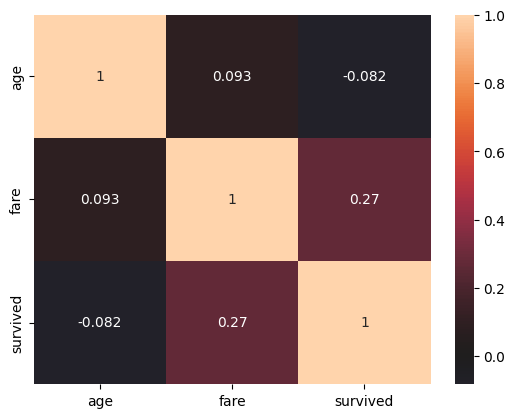

In [137]:
"""Das variáveis numéricas, a única tem possui um pouco de correlação com linear com 'survived' é o preço da passagem."""
corr = df[numeric_columns+["survived"]].corr()
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)

In [138]:
#Normalizando variáveis numéricas
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df[categoric_columns] = df[categoric_columns].replace({True: 1, False: 0})
df.head()

,survived,pclass,age,fare,who,embark_town,alone
0,0,3,-0.527669,-0.516380,man,Southampton,0
1,1,1,0.577094,0.694046,woman,Cherbourg,0
2,1,3,-0.251478,-0.503620,woman,Southampton,1
3,1,1,0.369951,0.350326,woman,Southampton,0
4,0,3,0.369951,-0.501257,man,Southampton,1


In [139]:
#Codificando variáveis categóricas
df_with_dummy = pd.get_dummies(df, columns=categoric_columns)
categoric_columns = df_with_dummy.columns.difference(numeric_columns)
df_with_dummy[categoric_columns] = df_with_dummy[categoric_columns].replace({True: 1, False: 0})
df_with_dummy.head()

,age,fare,alone_0,alone_1,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,pclass_1,pclass_2,pclass_3,survived_0,survived_1,who_child,who_man,who_woman
0,-0.527669,-0.516380,1,0,0,0,1,0,0,1,1,0,0,1,0
1,0.577094,0.694046,1,0,1,0,0,1,0,0,0,1,0,0,1
2,-0.251478,-0.503620,0,1,0,0,1,0,0,1,0,1,0,0,1
3,0.369951,0.350326,1,0,0,0,1,1,0,0,0,1,0,0,1
4,0.369951,-0.501257,0,1,0,0,1,0,0,1,1,0,0,1,0


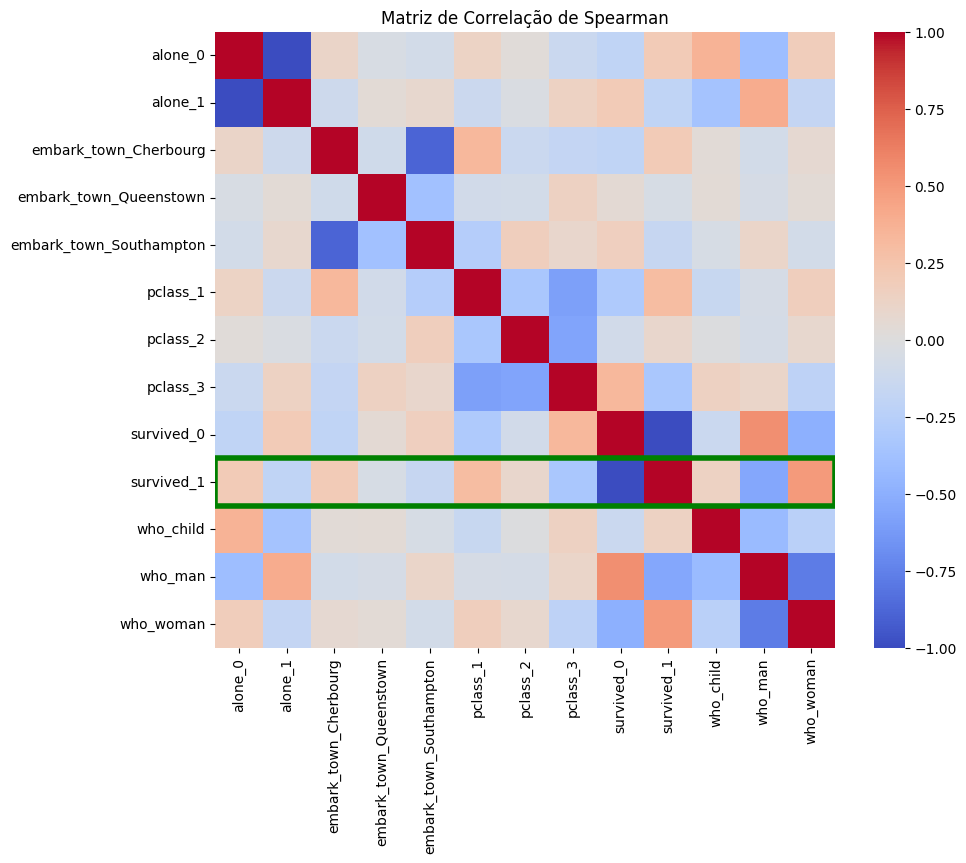

In [116]:
"""Calculando correlação de Spearman para as variáveis categóricas.
   Notamos que mulheres e crianças acompanhadas, que embarcaram em Cherbourg, da primiera classe possuem mais chance de sobreviver"""
categoric_df = df_with_dummy[categoric_columns]
spearman_corr = categoric_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, cmap='coolwarm')

index_survived_1 = spearman_corr.index.get_loc('survived_1')
column_survived_1 = spearman_corr.columns.get_loc(categoric_columns[0])
plt.gca().add_patch(plt.Rectangle((column_survived_1, index_survived_1), len(categoric_columns), 1, fill=False, edgecolor='green', lw=4))

plt.title('Matriz de Correlação de Spearman')
plt.show()

Rodamos o algoritmo K-menas com k variando de 2 até 20 e plotamos um gráfico para analisar a variância para cada um deles.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

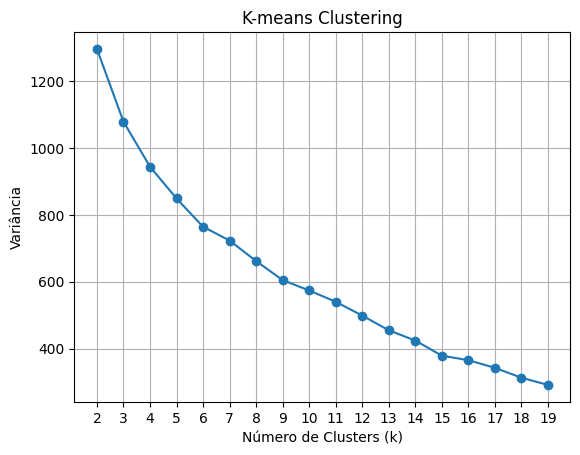

In [117]:
#Tendo em vista que a informação de 'fare' e 'age' já estão implicitamente em 'who' e 'pclass' respectivamente, acabamos por retirar essas duas variáveis.
X = df_with_dummy.drop(columns=['age', 'fare'])
X_array = X.values
inertia_scores = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_array)
    inertia_scores.append(kmeans.inertia_)

plt.plot(range(2, 20), inertia_scores, marker='o')
plt.title('K-means Clustering')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Variância')
plt.xticks(range(2, 20))
plt.grid(True)
plt.show()

Podemos reparar que a partir do k=6, a variância começa a diminuir um pouco mais lento, assim sendo, definimos que nosso agrupamento terá 6 clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


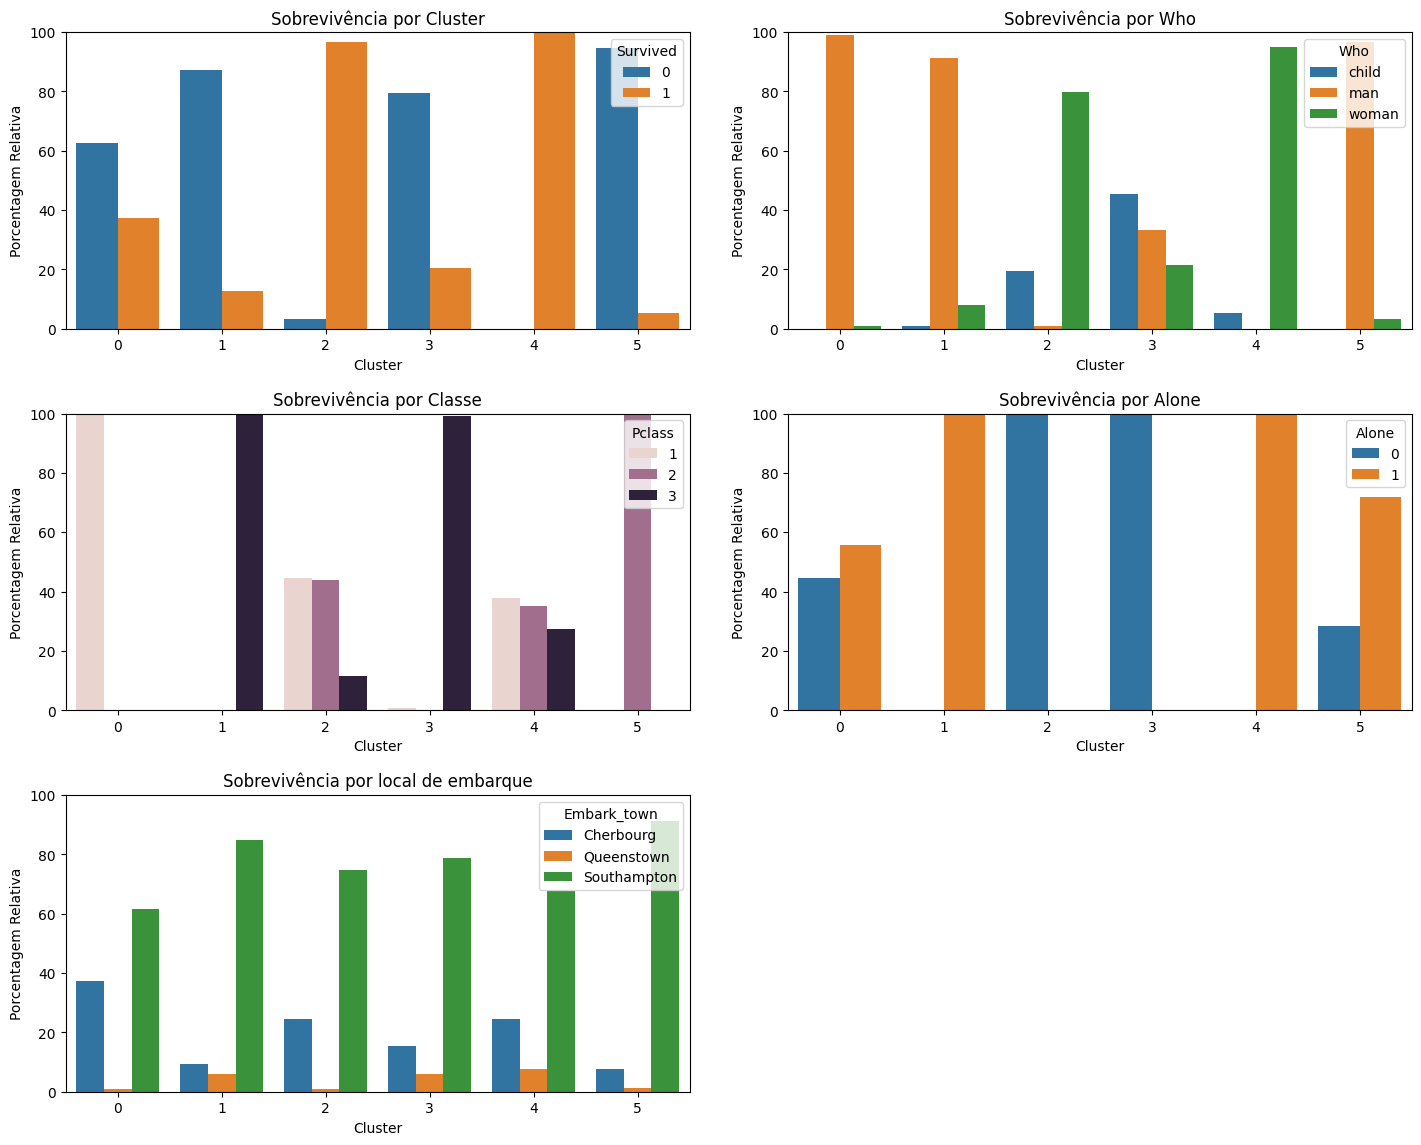

In [140]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_array)
df['cluster'] = clusters

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.tight_layout(pad=4.0)

plot_relative_percentage(axs[0, 0], df, x='cluster', hue='survived', title='Sobrevivência por Cluster')
plot_relative_percentage(axs[0, 1], df, x='cluster', hue='who', title='Sobrevivência por Who')
plot_relative_percentage(axs[1, 0], df, x='cluster', hue='pclass', title='Sobrevivência por Classe')
plot_relative_percentage(axs[1, 1], df, x='cluster', hue='alone', title='Sobrevivência por Alone')
plot_relative_percentage(axs[2, 0], df, x='cluster', hue='embark_town', title='Sobrevivência por local de embarque')

axs[2, 1].axis('off')

plt.show()

**Análises gerais dos grupos:**

Grupo 0 - Homens da primeira classe (morreram a maioria)

Grupo 1 - Homens da terceira classe (morreram quase todos)

Grupo 2 - Mulheres acompanhadas (sobreviveram quase todas)

Grupo 3 - Passageiros acompanhados na terceira classe (morreram a maioria)

Grupo 4 - Mulheres sozinhas (sobreviveram quase todas)

Grupo 5 - Homens da primeira classe (morreram a maioria)

Grupo 6 - Homens sozinhos da segunda classe (morreram a maioria)

Aplicando

Tentamos rodar o algoritmo hierarquico utilizando single, complete e average linkage, porém gerou muitos clusters diferentes. Dessa forma, procuramos outro método e o que encontramos foi o de "ward", que busca minimizar a soma das variâncias dentro dos clusters. Com isso, conseguimos clusters mais bem definidos e gerais.

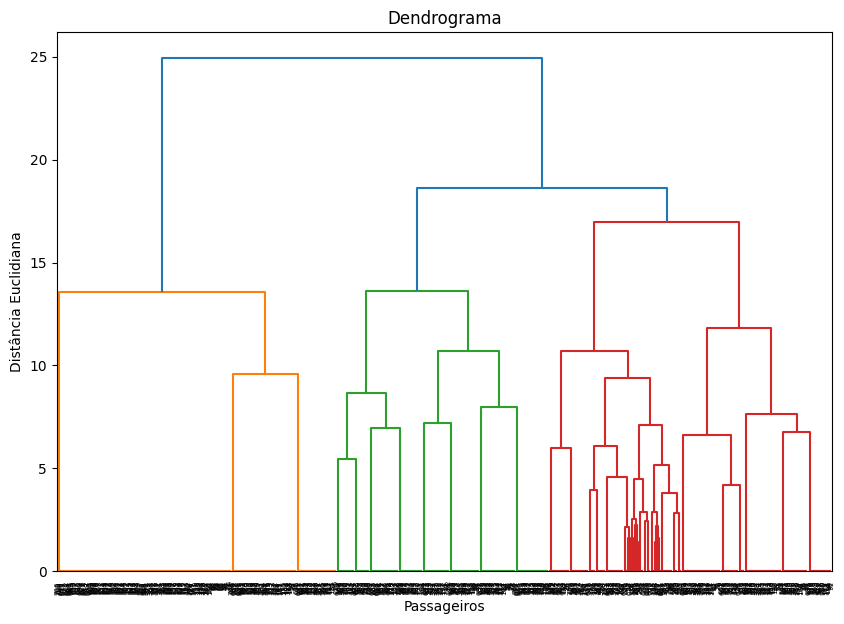

In [119]:
X = df_with_dummy.drop(columns=['survived_0', 'survived_1', 'age', 'fare'])

Z = linkage(X, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma')
plt.xlabel('Passageiros')
plt.ylabel('Distância Euclidiana')
plt.show()

In [120]:
clusters_hierarchical = fcluster(Z, t=6, criterion='maxclust')
df['cluster_hierarchical'] = clusters_hierarchical

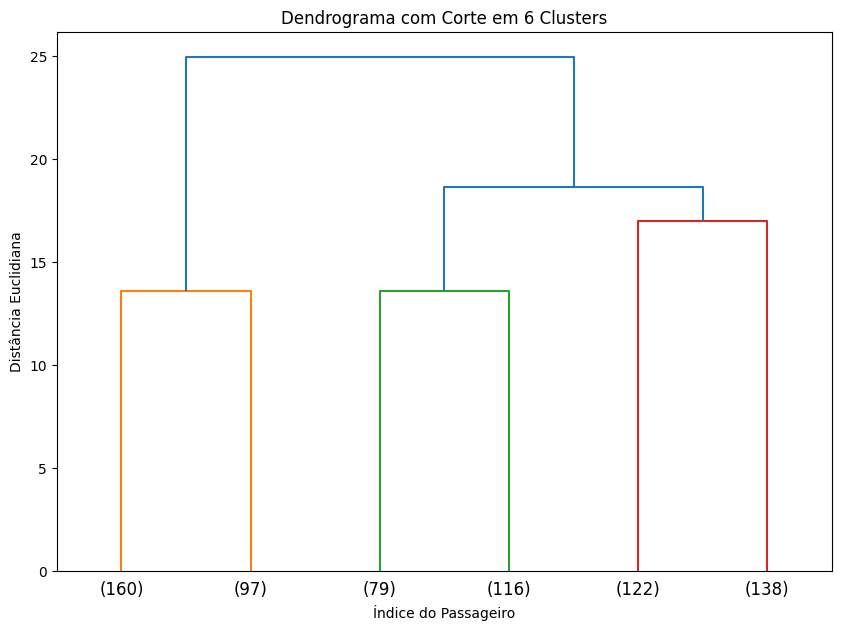

In [121]:
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=6)
plt.title('Dendrograma com Corte em 6 Clusters')
plt.xlabel('Índice do Passageiro')
plt.ylabel('Distância Euclidiana')
plt.show()

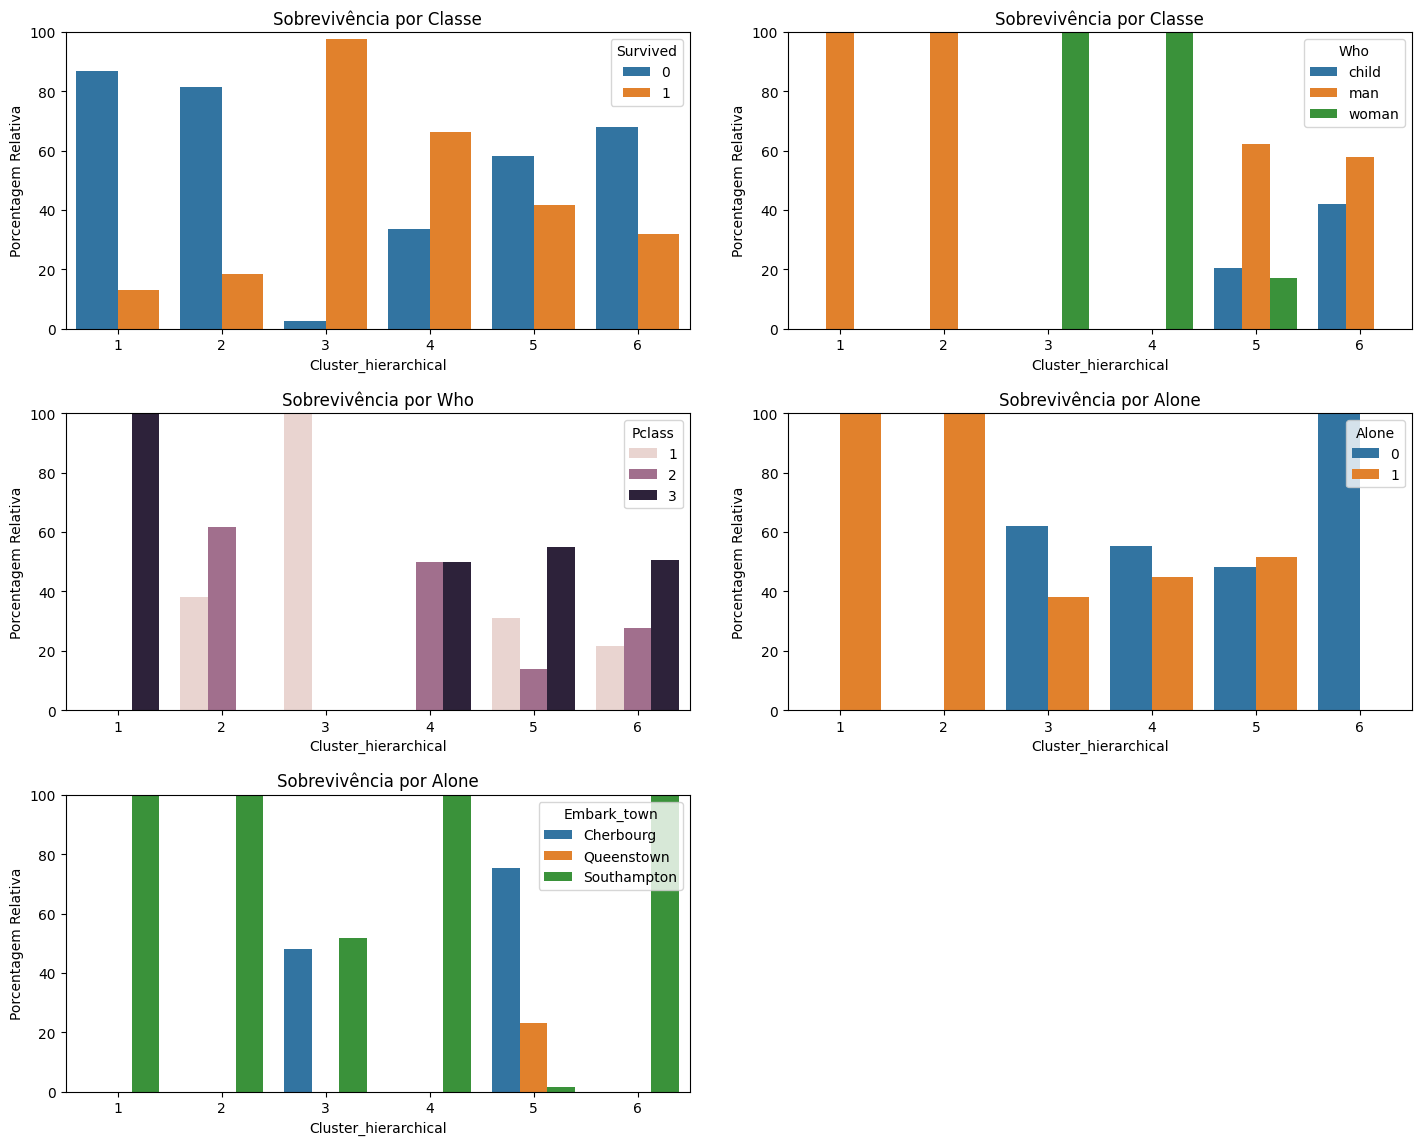

In [122]:
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.tight_layout(pad=4.0)

plot_relative_percentage(axs[0, 0], df, x='cluster_hierarchical', hue='survived', title='Sobrevivência por Cluster')
plot_relative_percentage(axs[0, 1], df, x='cluster_hierarchical', hue='who', title='Sobrevivência por Who')
plot_relative_percentage(axs[1, 0], df, x='cluster_hierarchical', hue='pclass', title='Sobrevivência por Classe')
plot_relative_percentage(axs[1, 1], df, x='cluster_hierarchical', hue='alone', title='Sobrevivência por Alone')
plot_relative_percentage(axs[2, 0], df, x='cluster_hierarchical', hue='embark_town', title='Sobrevivência por local de embarque')

axs[2, 1].axis('off')
plt.show()

**Análises gerais dos grupos:**

Grupo 1 - Homens da terceira classe sozinhos que embarcaram em Southanoton (morreram)

Grupo 2 - Homens da primeira e segunda classe sozinhos que embarcaram em Southanoton (morreram)

Grupo 3 - Mulheres da primeira classe (sobreviveram quase todas)

Grupo 4 - Mulheres da segunda e terceira classe que embarcaram em Southanoton (morreram quase 40%)

Grupo 5 - Meio mesclado, mas no geral homens que embarcaram em Cherbourg

Grupo 6 - Passageiros acompanhados que embarcaram em Southanoton